In [1]:
"""
Philosophy of this network:
    The goal that I had while writing this was for me to cement my understanding of the basic fully connected feed-forward network.
    My original implementation was quite slow, as it was not taking advantage of numpy vectorization - this version does. You can compare
    the previous version of this file to this one (filename nn.py, commit 9cb3da3ce582e940ed862f95930879c8be1721d1), and see the 
    significant training speed differences. I will say, adding vectorization makes the code less readable (and also increases the
    required memory) as I had to pad all vectors and matricies with zeros so each set of data had the same shape (and therefore it could be vectorized).
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from loss_fcns import squared_loss, cross_entropy_loss
from activations import eLU, ReLU, leaky_ReLU, sigmoid, linear, tanh, softmax


np.set_printoptions(suppress=True)
np.random.seed(1337)


In [2]:
def greater_than_9():
    def _get_one_hot(targets, num_classes):
        """
        targets (num_samples,)
        output  (num_classes, num_samples)
        """
        ret = np.zeros((num_classes, targets.shape[0]))
        ret[targets, np.arange(targets.size)] = 1
        return ret

    return (
        np.load("fake_data/X_train.npy"),
        _get_one_hot(np.load("fake_data/Y_train.npy"), 2),
        np.load("fake_data/X_test.npy"),
        _get_one_hot(np.load("fake_data/Y_test.npy"), 2),
    )


def mnist():
    def _get_one_hot(targets, num_classes):
        """
        targets (num_samples,)
        output  (num_classes, num_samples)
        """
        ret = np.zeros((num_classes, targets.shape[0]))
        ret[targets, np.arange(targets.size)] = 1
        return ret

    def load_data(fname):
        data_folder = "mnist_data/"
        with open(data_folder + fname, "rb") as f:
            data = f.read()
        return np.frombuffer(data, dtype=np.uint8)

    x_train = load_data("train-images-idx3-ubyte")
    y_train = load_data("train-labels-idx1-ubyte")
    x_test = load_data("t10k-images-idx3-ubyte")
    y_test = load_data("t10k-labels-idx1-ubyte")

    return (
        x_train[16:].reshape((28 * 28, -1), order="C"),
        _get_one_hot(y_train[8:], 10).reshape((10, -1)),
        x_test[16:].reshape((28 * 28, -1), order="C"),
        _get_one_hot(y_test[8:], 10).reshape((10, -1)),
    )

X_train, Y_train, X_test, Y_test = greater_than_9()
print("data loaded")

# net = ffnn.FFNN([784, 512, 128, 10], [tanh, tanh, softmax], cross_entropy_loss)
layers = [2, 2, 2]
hs = [ReLU, softmax]
cost_fcn = cross_entropy_loss

data loaded


In [3]:
def make_network(random=True):
    """
    random == False for generating empty weight/bias matricies
    """
    layer_arr = layers

    weights = []
    biases = []

    layer_iter = iter(layer_arr)
    prev_dim = layer_iter.__next__()

    for i, dim in enumerate(layer_iter):
        if random:
            bound = np.sqrt(2 / layer_arr[i])
            weight_matrix = np.random.uniform(low=-bound, high=bound, size=(dim, prev_dim)).astype(np.float32)
            biases_matrix = np.random.uniform(low=-bound, high=bound, size=(dim, 1)).astype(np.float32)
        else:
            weight_matrix = np.zeros((dim, prev_dim), dtype=np.float32)
            biases_matrix = np.zeros((dim, 1), dtype=np.float32)

        weights.append(weight_matrix)
        biases.append(biases_matrix)
        prev_dim = dim

    return weights, biases

weights, biases = make_network()

In [4]:
def feed_forward(xs, training=False):
    """
    Feed-forward through the network, saving the activations and non-linearities
    after each layer for backprop.

    xs has to be of shape (num features, batch_size)
    - x, z, a are all vectors of inputs, outputs, and linear outputs at layers
    """
    zs = []
    activations = []

    activation = xs.astype(np.float32) / 255
    activations.append(activation)
    for i, (W, b) in enumerate(zip(weights, biases)):
        z = np.einsum("ij, jb -> ib", W, activation) + b
        zs.append(z)
        activation = hs[i].f(z)
        activations.append(activation)

    return (activation, activations, zs) if training else activation

d1 = np.asarray([[1],[1]])
print(d1.shape, feed_forward(d1).sum())

d2 = np.asarray([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],[9,8,7,6,5,4,3,2,1,0]])
print(d2.shape, feed_forward(d2).sum())

print(X_train[:,:10].shape, feed_forward(X_train[:,:10]).sum())


(2, 1) 1.0
(2, 10) 10.0
(2, 10) 10.000001


In [5]:
def back_prop(xs, ts):
    """
    xs,ts are lists of vectors (ts are targets for training i.e. true output given input x)
    """
    weight_grads, bias_grads = make_network(random=False)
    ys, activations, zs = feed_forward(xs, training=True)

    # delta_L = grad cost_fcn(outputs) * activation_fcn.deriv(weighted_output_last_layer)
    # should be hadamard product
    # Also, ys is just activations[-1]
    assert ts.shape == ys.shape

    delta = cost_fcn.deriv(ts, ys) * hs[-1].deriv(zs[-1])
    batch_weights = np.einsum("ib, jb -> ijb", delta, activations[-2])

    # sum along batch
    bias_grads[-1][:, :] = np.mean(delta, axis=-1).reshape(-1, 1)
    weight_grads[-1][:, :] = np.mean(batch_weights, axis=-1)

    # back propogate through layers
    for l in range(2, len(layers)):
        nonlinear_deriv = hs[-l].deriv(zs[-l])
        delta = np.dot(weights[-l + 1].T, delta) * nonlinear_deriv
        batch_weights = np.einsum("ib, jb -> ijb", delta, activations[-l - 1])

        bias_grads[-l][:, :] = np.mean(delta, axis=-1).reshape(-1, 1)
        weight_grads[-l][:, :] = np.mean(batch_weights, axis=-1)

    for new_b, new_g, self_b, self_g in zip(bias_grads, weight_grads, biases, weights):
        assert new_b.shape == self_b.shape
        assert new_g.shape == self_g.shape

    return weight_grads, bias_grads

m = 1
n = 10
back_prop(X_train[:,m:m+n], Y_train[:,m:m+n]), X_train[:,m:m+n], Y_train[:,m:m+n]
X_train[:,m:m+1], feed_forward(X_train[:,m:m+1])

(array([[9],
        [3]]),
 array([[0.38942432],
        [0.6105757 ]], dtype=float32))

In [6]:
def mini_batch(batch_xs, batch_ys, lr):
    """
    batch_xs is the batch of inputs, batch_ys is batch of outputs, lr is learning rate
    """
    global weights, biases
    weight_grads, bias_grads = back_prop(batch_xs, batch_ys)

    weights = [
        w - lr * weight_grad for w, weight_grad in zip(weights, weight_grads)
    ]
    biases = [b - lr * bias_grad for b, bias_grad in zip(biases, bias_grads)]


In [7]:
def learn(xs, ys, epochs, batch_size, lr):
    """
    xs/ys is the input/output data, epochs is
    the number of batches to train, batch size is the number of input/outputs to
    use in each batch, and lr is learning rate.

    xs, ys have the input vectors as COLUMNS, so xs shape should be (num_features, batch_size)
    e.g. with MNIST, each image is 28*28=784 features, so xs is (784, 60000)
    since there are 10 classes in mnist, y should be (10, 60000)
    """
    losses = []
    accuracies = []
    # get random indicies from batch
    random_indicies = np.random.choice(xs.shape[1], size=batch_size)
    for epoch in range(epochs):
        mini_batch(xs[:, random_indicies], ys[:, random_indicies], lr)

        ts = ys[:, random_indicies]
        ys_out_test = feed_forward(xs[:, random_indicies])

        loss = cost_fcn.f(ts, ys_out_test)
        train_loss = np.mean(loss)

        losses.append(train_loss)
        accuracies.append(np.sum(np.argmax(ts, axis=0) == np.argmax(ys_out_test, axis=0)) / ts.shape[-1])

        if epoch % 50 == 0:
            print(f"epoch {epoch} \t train loss {train_loss:.8f}")

    return losses, accuracies


In [8]:
losses, accuracies = learn(X_train, Y_train, 100000, 128, 1)

epoch 0 	 train loss 0.71116486
epoch 50 	 train loss 0.68349109
epoch 100 	 train loss 0.68249348
epoch 150 	 train loss 0.68138074
epoch 200 	 train loss 0.68012586
epoch 250 	 train loss 0.67869874
epoch 300 	 train loss 0.67706579
epoch 350 	 train loss 0.67518935
epoch 400 	 train loss 0.67302738
epoch 450 	 train loss 0.67053290
epoch 500 	 train loss 0.66765387
epoch 550 	 train loss 0.66433304
epoch 600 	 train loss 0.66050811
epoch 650 	 train loss 0.65611235
epoch 700 	 train loss 0.65107563
epoch 750 	 train loss 0.64532606
epoch 800 	 train loss 0.63879273
epoch 850 	 train loss 0.63140896
epoch 900 	 train loss 0.62311698
epoch 950 	 train loss 0.61387332
epoch 1000 	 train loss 0.60365493
epoch 1050 	 train loss 0.77176999
epoch 1100 	 train loss 0.63693956
epoch 1150 	 train loss 0.63305586
epoch 1200 	 train loss 0.62960710
epoch 1250 	 train loss 0.62634727
epoch 1300 	 train loss 0.62317843
epoch 1350 	 train loss 0.62006210
epoch 1400 	 train loss 0.61698246
epoch 14

epoch 12200 	 train loss 0.25345581
epoch 12250 	 train loss 0.25284129
epoch 12300 	 train loss 0.25223149
epoch 12350 	 train loss 0.25162707
epoch 12400 	 train loss 0.25102773
epoch 12450 	 train loss 0.25043368
epoch 12500 	 train loss 0.24984459
epoch 12550 	 train loss 0.24925989
epoch 12600 	 train loss 0.24868092
epoch 12650 	 train loss 0.24810597
epoch 12700 	 train loss 0.24753638
epoch 12750 	 train loss 0.24697121
epoch 12800 	 train loss 0.24641097
epoch 12850 	 train loss 0.24585533
epoch 12900 	 train loss 0.24530405
epoch 12950 	 train loss 0.24475795
epoch 13000 	 train loss 0.24421566
epoch 13050 	 train loss 0.24367821
epoch 13100 	 train loss 0.24314498
epoch 13150 	 train loss 0.24261606
epoch 13200 	 train loss 0.24209174
epoch 13250 	 train loss 0.24157116
epoch 13300 	 train loss 0.24105543
epoch 13350 	 train loss 0.24071027
epoch 13400 	 train loss 0.24018437
epoch 13450 	 train loss 0.23966488
epoch 13500 	 train loss 0.23915104
epoch 13550 	 train loss 0.2

epoch 23950 	 train loss 0.18061785
epoch 24000 	 train loss 0.18043360
epoch 24050 	 train loss 0.18026363
epoch 24100 	 train loss 0.18009469
epoch 24150 	 train loss 0.17992629
epoch 24200 	 train loss 0.17975850
epoch 24250 	 train loss 0.17959058
epoch 24300 	 train loss 0.17944103
epoch 24350 	 train loss 0.17927307
epoch 24400 	 train loss 0.17910596
epoch 24450 	 train loss 0.17893951
epoch 24500 	 train loss 0.17877309
epoch 24550 	 train loss 0.17860743
epoch 24600 	 train loss 0.17844256
epoch 24650 	 train loss 0.17827829
epoch 24700 	 train loss 0.17811421
epoch 24750 	 train loss 0.17795054
epoch 24800 	 train loss 0.17778797
epoch 24850 	 train loss 0.17762577
epoch 24900 	 train loss 0.17746358
epoch 24950 	 train loss 0.17730213
epoch 25000 	 train loss 0.17714152
epoch 25050 	 train loss 0.17698109
epoch 25100 	 train loss 0.17682080
epoch 25150 	 train loss 0.17664924
epoch 25200 	 train loss 0.17649107
epoch 25250 	 train loss 0.17633339
epoch 25300 	 train loss 0.1

epoch 35500 	 train loss 0.15042785
epoch 35550 	 train loss 0.15032355
epoch 35600 	 train loss 0.15022018
epoch 35650 	 train loss 0.15011674
epoch 35700 	 train loss 0.15001342
epoch 35750 	 train loss 0.14991012
epoch 35800 	 train loss 0.14980685
epoch 35850 	 train loss 0.14970378
epoch 35900 	 train loss 0.14960073
epoch 35950 	 train loss 0.14949745
epoch 36000 	 train loss 0.14939535
epoch 36050 	 train loss 0.14929340
epoch 36100 	 train loss 0.14919150
epoch 36150 	 train loss 0.14908947
epoch 36200 	 train loss 0.14898742
epoch 36250 	 train loss 0.14888556
epoch 36300 	 train loss 0.14878374
epoch 36350 	 train loss 0.14868204
epoch 36400 	 train loss 0.14858120
epoch 36450 	 train loss 0.14848057
epoch 36500 	 train loss 0.14837989
epoch 36550 	 train loss 0.14827889
epoch 36600 	 train loss 0.14817801
epoch 36650 	 train loss 0.14807759
epoch 36700 	 train loss 0.14797723
epoch 36750 	 train loss 0.14787695
epoch 36800 	 train loss 0.14777683
epoch 36850 	 train loss 0.1

epoch 47100 	 train loss 0.13010470
epoch 47150 	 train loss 0.13003193
epoch 47200 	 train loss 0.12995918
epoch 47250 	 train loss 0.12988675
epoch 47300 	 train loss 0.12981449
epoch 47350 	 train loss 0.12974220
epoch 47400 	 train loss 0.12966988
epoch 47450 	 train loss 0.12959724
epoch 47500 	 train loss 0.12952503
epoch 47550 	 train loss 0.12945305
epoch 47600 	 train loss 0.12938115
epoch 47650 	 train loss 0.12930932
epoch 47700 	 train loss 0.12923760
epoch 47750 	 train loss 0.12916586
epoch 47800 	 train loss 0.12909405
epoch 47850 	 train loss 0.12902281
epoch 47900 	 train loss 0.12895185
epoch 47950 	 train loss 0.12888094
epoch 48000 	 train loss 0.12880971
epoch 48050 	 train loss 0.12873835
epoch 48100 	 train loss 0.12866747
epoch 48150 	 train loss 0.12859659
epoch 48200 	 train loss 0.12852562
epoch 48250 	 train loss 0.12845472
epoch 48300 	 train loss 0.12838427
epoch 48350 	 train loss 0.12831381
epoch 48400 	 train loss 0.12824341
epoch 48450 	 train loss 0.1

epoch 58800 	 train loss 0.11546407
epoch 58850 	 train loss 0.11541048
epoch 58900 	 train loss 0.11535681
epoch 58950 	 train loss 0.11530318
epoch 59000 	 train loss 0.11524959
epoch 59050 	 train loss 0.11519615
epoch 59100 	 train loss 0.11514275
epoch 59150 	 train loss 0.11508984
epoch 59200 	 train loss 0.11503703
epoch 59250 	 train loss 0.11498417
epoch 59300 	 train loss 0.11493137
epoch 59350 	 train loss 0.11487863
epoch 59400 	 train loss 0.11482576
epoch 59450 	 train loss 0.11477305
epoch 59500 	 train loss 0.11472072
epoch 59550 	 train loss 0.11466872
epoch 59600 	 train loss 0.11461677
epoch 59650 	 train loss 0.11456468
epoch 59700 	 train loss 0.11451252
epoch 59750 	 train loss 0.11445999
epoch 59800 	 train loss 0.11440748
epoch 59850 	 train loss 0.11435487
epoch 59900 	 train loss 0.11430274
epoch 59950 	 train loss 0.11425070
epoch 60000 	 train loss 0.11419863
epoch 60050 	 train loss 0.11414666
epoch 60100 	 train loss 0.11409466
epoch 60150 	 train loss 0.1

epoch 70200 	 train loss 0.10482094
epoch 70250 	 train loss 0.10478059
epoch 70300 	 train loss 0.10473999
epoch 70350 	 train loss 0.10469971
epoch 70400 	 train loss 0.10465900
epoch 70450 	 train loss 0.10461879
epoch 70500 	 train loss 0.10457819
epoch 70550 	 train loss 0.10453798
epoch 70600 	 train loss 0.10449742
epoch 70650 	 train loss 0.10445703
epoch 70700 	 train loss 0.10441672
epoch 70750 	 train loss 0.10437641
epoch 70800 	 train loss 0.10433617
epoch 70850 	 train loss 0.10429569
epoch 70900 	 train loss 0.10425552
epoch 70950 	 train loss 0.10421525
epoch 71000 	 train loss 0.10417570
epoch 71050 	 train loss 0.10413626
epoch 71100 	 train loss 0.10409678
epoch 71150 	 train loss 0.10405720
epoch 71200 	 train loss 0.10401771
epoch 71250 	 train loss 0.10397818
epoch 71300 	 train loss 0.10393868
epoch 71350 	 train loss 0.10389933
epoch 71400 	 train loss 0.10385989
epoch 71450 	 train loss 0.10382045
epoch 71500 	 train loss 0.10378103
epoch 71550 	 train loss 0.1

epoch 81650 	 train loss 0.09658660
epoch 81700 	 train loss 0.09655457
epoch 81750 	 train loss 0.09652313
epoch 81800 	 train loss 0.09649155
epoch 81850 	 train loss 0.09646024
epoch 81900 	 train loss 0.09642869
epoch 81950 	 train loss 0.09639746
epoch 82000 	 train loss 0.09636589
epoch 82050 	 train loss 0.09633447
epoch 82100 	 train loss 0.09630277
epoch 82150 	 train loss 0.09627133
epoch 82200 	 train loss 0.09623982
epoch 82250 	 train loss 0.09620838
epoch 82300 	 train loss 0.09617679
epoch 82350 	 train loss 0.09614561
epoch 82400 	 train loss 0.09611418
epoch 82450 	 train loss 0.09608268
epoch 82500 	 train loss 0.09605118
epoch 82550 	 train loss 0.09601987
epoch 82600 	 train loss 0.09598848
epoch 82650 	 train loss 0.09595722
epoch 82700 	 train loss 0.09592592
epoch 82750 	 train loss 0.09589461
epoch 82800 	 train loss 0.09586334
epoch 82850 	 train loss 0.09583208
epoch 82900 	 train loss 0.09580094
epoch 82950 	 train loss 0.09576981
epoch 83000 	 train loss 0.0

epoch 93300 	 train loss 0.09005042
epoch 93350 	 train loss 0.09002622
epoch 93400 	 train loss 0.09000217
epoch 93450 	 train loss 0.08997818
epoch 93500 	 train loss 0.08995419
epoch 93550 	 train loss 0.08993011
epoch 93600 	 train loss 0.08990587
epoch 93650 	 train loss 0.08988164
epoch 93700 	 train loss 0.08985726
epoch 93750 	 train loss 0.08983310
epoch 93800 	 train loss 0.08980885
epoch 93850 	 train loss 0.08978552
epoch 93900 	 train loss 0.08976155
epoch 93950 	 train loss 0.08973722
epoch 94000 	 train loss 0.08971291
epoch 94050 	 train loss 0.08968886
epoch 94100 	 train loss 0.08966466
epoch 94150 	 train loss 0.08964109
epoch 94200 	 train loss 0.08961692
epoch 94250 	 train loss 0.08959312
epoch 94300 	 train loss 0.08956894
epoch 94350 	 train loss 0.08954486
epoch 94400 	 train loss 0.08952064
epoch 94450 	 train loss 0.08949657
epoch 94500 	 train loss 0.08947251
epoch 94550 	 train loss 0.08944855
epoch 94600 	 train loss 0.08942447
epoch 94650 	 train loss 0.0

Test loss: 0.076
Test accuracy: 1.000


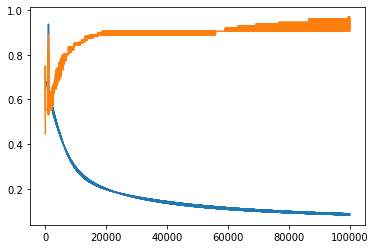

In [9]:
np.save("weights.npy", np.asarray(weights, dtype=object))
np.save("biases.npy", np.asarray(biases, dtype=object))

test_out = feed_forward(X_test)
test_argmax = np.argmax(test_out, axis=0)
Y_test_argmax = np.argmax(Y_test, axis=0)

test_losses = cross_entropy_loss.f(Y_test, test_out)
print("Test loss: {:.3f}".format(np.mean(test_losses)))
print("Test accuracy: {:.3f}".format(np.sum(Y_test == test_argmax) / Y_test.shape[1]))

samp_loss = sorted(zip(X_test.T, test_losses), key=lambda v: v[1])

plt.plot(range(len(losses)), losses)
plt.plot(range(len(accuracies)), accuracies)
plt.show()
